<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/music4all_tf_idf_by_genre_and_lang_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The goal of this notebook is to apply TF-IDF, statistical machine learning approach to the Music4All datasets. This study only work on the top20 genre and top10 language since lower ranks do not have enough data volume.

For grouped by artists, see https://colab.research.google.com/drive/1Vzrrz54NfcOBm_-de7TwaG4oYuMfvbcF#scrollTo=HEJ1YocLRzCk


In [1]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 5.7 MB/s 


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [4]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [5]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

# Find top20 genre

id_genres.csv

Number of genres: 853


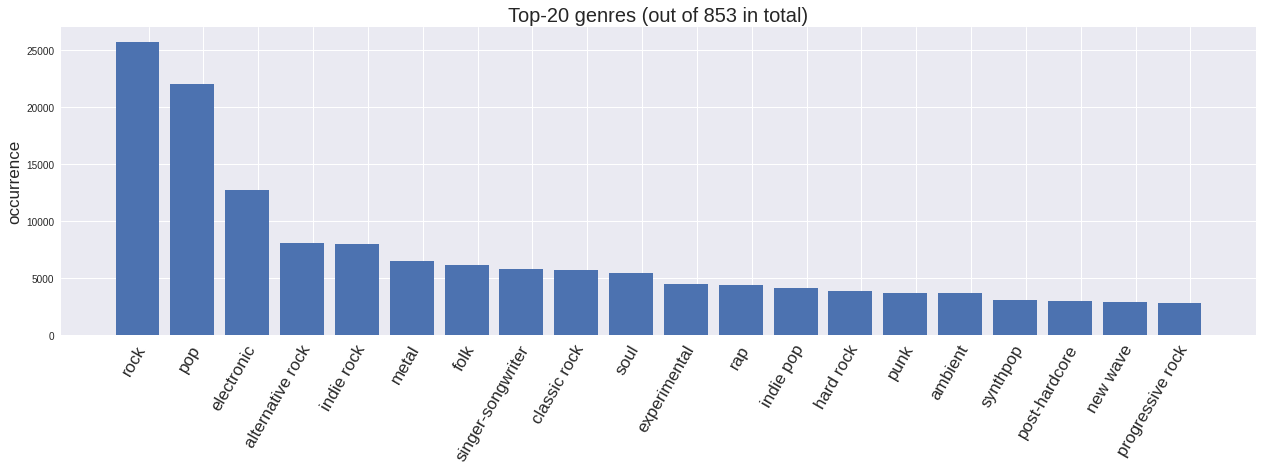

In [ ]:
_ = analyze_genre_tag_csv('id_genres.csv', top_n=20)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

In [6]:
#create List of top20 genre
top20_genre=["rock","pop", "electronic","alternative rock","indie rock", 
              "metal","folk","singer-songwriter","classic rock","soul"
              ,"experimental","rap","indie pop","hard rock","punk"
              ,"ambient","synthpop","post-hardcore","new wave","progressive rock"]

#filter genre dataset as top20 genre only.
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')
df_genre_top20 = df_genres[df_genres['genres'].isin(top20_genre)]
df_genre_top20

,id,genres
0,0009fFIM1eYThaPg,pop
11,00P2bHdWFkghmDqz,soul
14,00XWljDxNBgBKEEA,pop
16,00b6fV3nx5z2b8Ls,pop
26,013QDoTqbexEwkHr,pop
...,...,...
109253,zzgS4ZqyswamEWNj,pop
109254,zziALZG1JQ2uUjcy,metal
109262,zzx8CWdM7qkxKQpC,indie rock
109265,zzz0n04uuTUA7fNh,pop


Number of genres: 20


Counter({'alternative rock': 384,
         'ambient': 330,
         'classic rock': 185,
         'electronic': 1305,
         'experimental': 257,
         'folk': 1017,
         'hard rock': 203,
         'indie pop': 714,
         'indie rock': 1182,
         'metal': 175,
         'new wave': 169,
         'pop': 6092,
         'post-hardcore': 267,
         'progressive rock': 234,
         'punk': 402,
         'rap': 1431,
         'rock': 1887,
         'singer-songwriter': 794,
         'soul': 1337,
         'synthpop': 238})

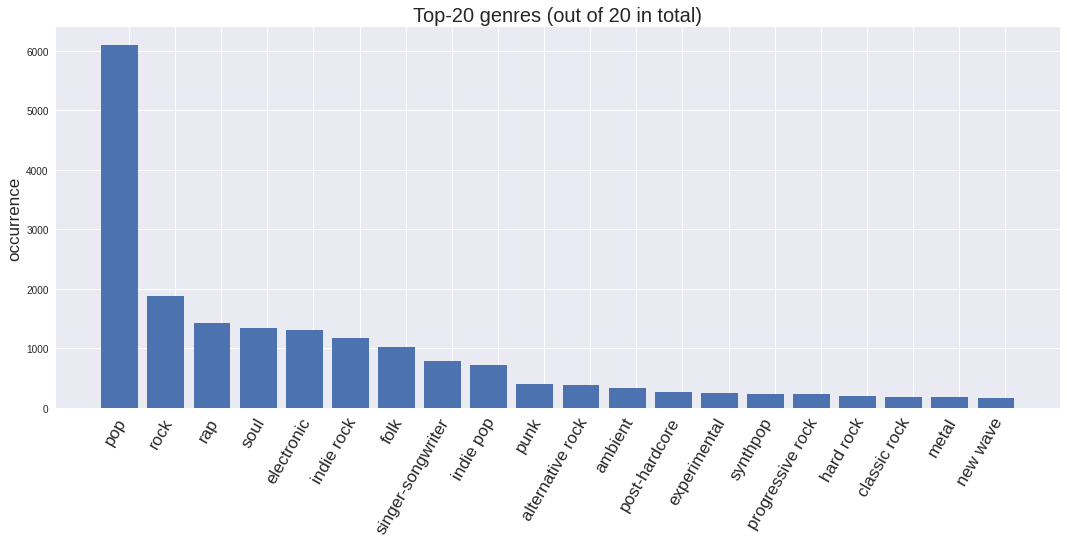

In [ ]:
analyze_genre_tag_df(df_genre_top20,20)

## Dataframe narrowed down to 18603 rows. Notice that rank20 has only 169 data. So depending on the result we might need to narrow down to top10 genre?

# find top10 language

Number of lang: 46
Counter({'en': 84103, 'INTRUMENTAL': 9417, 'pt': 7020, 'es': 3225, 'ko': 1145, 'fr': 994, 'ja': 615, 'de': 577, 'pl': 446, 'it': 437, 'sv': 231, 'ru': 187, 'id': 140, 'tr': 125, 'fi': 105, 'no': 99, 'nl': 59, 'tl': 42, 'hr': 41, 'hu': 27, 'sw': 21, 'uk': 20, 'el': 18, 'ca': 18, 'ro': 18, 'da': 17, 'ar': 17, 'et': 16, 'so': 16, 'vi': 13, 'af': 8, 'lt': 7, 'cy': 7, 'sl': 7, 'fa': 6, 'sq': 5, 'th': 4, 'zh-cn': 4, 'pa': 2, 'lv': 2, 'bn': 2, 'cs': 2, 'hi': 1, 'sk': 1, 'bg': 1, 'he': 1})


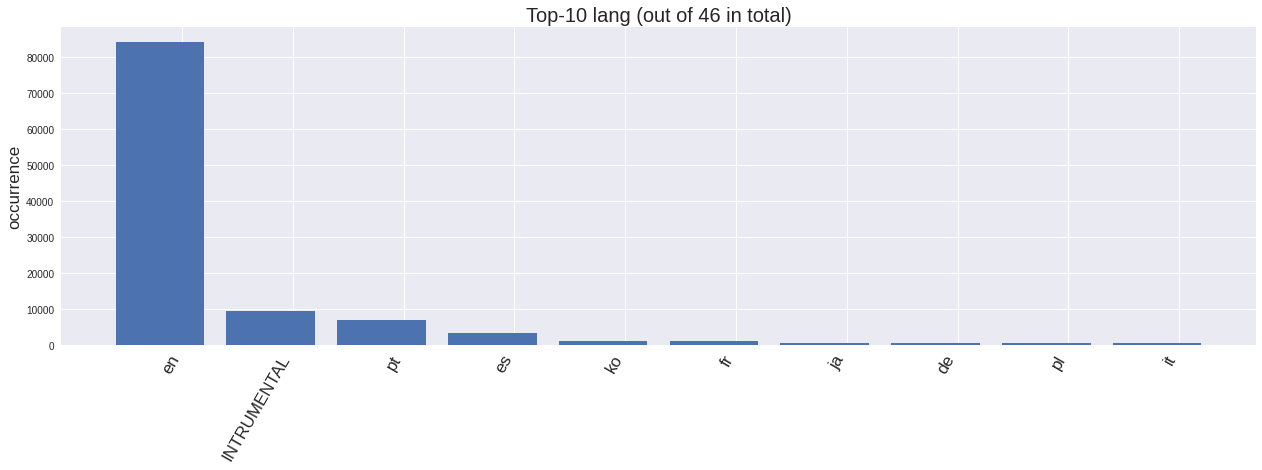

In [ ]:
labels_counter = analyze_genre_tag_csv('id_lang.csv', top_n=10)
print(labels_counter)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-language.png'))

In [7]:
# create List of top10 language
top_10_lang = ['en', 'INTRUMENTAL', 'pt', 'es', 'ko', 'fr', 'ja', 'de', 'pl', 'it']

# Filter dataset as top10 language
 Note that this split have overlapping artist in both sets. See artist-grouped-stratified-split for an improved version.

In [8]:
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_top10=df_lang[ df_lang['lang'].isin(top_10_lang) ]
df_lang_top10

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


### Originally it was 109269 rows, and now there are 107979 rows.

### Now, combine split by language and genre, so we classify each genre by language.

In [9]:
# merge three dataframes into one
df_genre_by_lang = pd.concat([df_genre_top20['id'], df_genre_top20['genres'], df_lang_top10['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_by_lang


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
11,00P2bHdWFkghmDqz,soul,en
14,00XWljDxNBgBKEEA,pop,es
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
...,...,...,...
109253,zzgS4ZqyswamEWNj,pop,en
109254,zziALZG1JQ2uUjcy,metal,en
109262,zzx8CWdM7qkxKQpC,indie rock,en
109265,zzz0n04uuTUA7fNh,pop,en


### Top20 genres are 18603 rows, and by taking intersection of language, our final dataset has 18345 rows, which is not bad.

# Split by every labels (tags, genres, language) -- multi-labeled
# I recommend to use this split by default for any task on Music4All

In [10]:
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split

In [11]:
class Splitter:
    def __init__(self, df, test_size=0.2, top_n=1000, random_seed=None):
        if random_seed is not None:
            np.random.seed(random_seed)
        
        self.random_seed = random_seed
            
        column_name = df.columns[1]
        print('column name: %s' % column_name)
        items = df[column_name].tolist()  # list of 'genre1, genre2,..'
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        
        items = Counter(items)
        item_labels = [item[0] for item in items.most_common(top_n)] 
        print('Total number of items considered in the split: %d' % len(item_labels))

        item_to_index = {item: i for (i, item) in enumerate(item_labels)}

        row_inds, col_inds = [], []
        
        # create sparse matrix
        for index, genre_names in zip(df.index, df[column_name]):
            genre_list = genre_names.split(',')
            for genre in genre_list:
                row_inds.append(index)
                col_inds.append(item_to_index[genre])

        self.sparse_labels = csr_matrix((np.ones(len(row_inds)), (row_inds, col_inds)))
        
        # perform splitting
        input_x = df.index
        input_x = input_x.to_numpy().reshape((-1, 1))
        X_train, y_train, X_test, y_test = iterative_train_test_split(input_x, self.sparse_labels, test_size=test_size)
        
        # print the result
        print(pd.DataFrame({
            'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train.A, order=2) for combination in row),
            'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test.A, order=2) for combination in row)
        }).T.fillna(0.0))
        
        self.column_name = column_name
        self.item_labels = item_labels
        self.items = items
        self.item_to_index = item_to_index
        self.split = X_train, y_train, X_test, y_test

## 5/2: Tags and genres sometimes overall, so added prefix then in the following code we merge all labels(=features).

In [12]:
#create df_all, which is putting lang and genre in a same column
# to run multi-label stratification.
df_genre_by_lang['all_labels'] = df_genre_by_lang[['genres', 'lang']].apply(lambda x: ','.join(x), axis=1)
df_genre_by_lang=df_genre_by_lang.drop(columns=['genres', 'lang'], axis=1)
df_genre_by_lang

,id,all_labels
0,0009fFIM1eYThaPg,"pop,en"
11,00P2bHdWFkghmDqz,"soul,en"
14,00XWljDxNBgBKEEA,"pop,es"
16,00b6fV3nx5z2b8Ls,"pop,en"
26,013QDoTqbexEwkHr,"pop,en"
...,...,...
109253,zzgS4ZqyswamEWNj,"pop,en"
109254,zziALZG1JQ2uUjcy,"metal,en"
109262,zzx8CWdM7qkxKQpC,"indie rock,en"
109265,zzz0n04uuTUA7fNh,"pop,en"


### Important Note: after filtering/sorting or any data manipulation on datasets, we need to reindex data frame. Otherwise, multi-label stratification fails due to shape mismatch of X and y.

In [13]:
df_genre_by_lang = df_genre_by_lang.reset_index(drop=True)
df_genre_by_lang

,id,all_labels
0,0009fFIM1eYThaPg,"pop,en"
1,00P2bHdWFkghmDqz,"soul,en"
2,00XWljDxNBgBKEEA,"pop,es"
3,00b6fV3nx5z2b8Ls,"pop,en"
4,013QDoTqbexEwkHr,"pop,en"
...,...,...
18340,zzgS4ZqyswamEWNj,"pop,en"
18341,zziALZG1JQ2uUjcy,"metal,en"
18342,zzx8CWdM7qkxKQpC,"indie rock,en"
18343,zzz0n04uuTUA7fNh,"pop,en"


In [ ]:
#check unique set of genre by lang
set(df_genre_by_lang['all_labels'])

{'alternative rock,INTRUMENTAL',
 'alternative rock,en',
 'alternative rock,es',
 'alternative rock,it',
 'alternative rock,pl',
 'alternative rock,pt',
 'ambient,INTRUMENTAL',
 'ambient,en',
 'classic rock,INTRUMENTAL',
 'classic rock,en',
 'classic rock,es',
 'classic rock,pt',
 'electronic,INTRUMENTAL',
 'electronic,de',
 'electronic,en',
 'electronic,es',
 'electronic,fr',
 'electronic,it',
 'electronic,ja',
 'electronic,pl',
 'electronic,pt',
 'experimental,INTRUMENTAL',
 'experimental,en',
 'experimental,es',
 'experimental,pl',
 'experimental,pt',
 'folk,INTRUMENTAL',
 'folk,de',
 'folk,en',
 'folk,es',
 'folk,fr',
 'folk,it',
 'folk,ko',
 'folk,pl',
 'folk,pt',
 'hard rock,INTRUMENTAL',
 'hard rock,en',
 'hard rock,es',
 'hard rock,pt',
 'indie pop,INTRUMENTAL',
 'indie pop,en',
 'indie pop,es',
 'indie pop,fr',
 'indie pop,it',
 'indie pop,pl',
 'indie pop,pt',
 'indie rock,INTRUMENTAL',
 'indie rock,de',
 'indie rock,en',
 'indie rock,es',
 'indie rock,fr',
 'indie rock,ja',


In [ ]:
len(set(df_genre_by_lang['all_labels']))

130

### So we want 130 labels, but Keunwoo Choi's split all considers language and genre distinctly, so the total label is 30 (top 10 language + top 20 genres), which is not what we want to experiment.

In [14]:
# it's gonna take 6 mins..
splitter_all = Splitter(df=df_genre_by_lang, top_n=None, random_seed=1209)

column name: all_labels
Total number of items considered in the split: 30
       (12, 12)  (1, 1)  (1, 12)  (0, 1)   (0, 0)  (8, 8)  (5, 5)  (5, 8)  \
train     377.0  4784.0    177.0  4143.0  12344.0   666.0  1033.0   233.0   
test       91.0  1195.0     44.0  1036.0   3086.0   164.0   259.0    58.0   

       (3, 10)  (3, 3)  ...  (7, 16)  (12, 24)  (11, 16)  (4, 16)  (6, 27)  \
train    145.0  1117.0  ...      2.0       1.0       2.0      1.0      2.0   
test      36.0   280.0  ...      1.0       0.0       0.0      0.0      0.0   

       (8, 25)  (19, 21)  (12, 23)  (19, 26)  (11, 21)  
train      1.0       1.0       1.0       2.0       1.0  
test       0.0       0.0       0.0       1.0       0.0  

[2 rows x 160 columns]


In [ ]:
X_train, y_train, X_test, y_test = splitter_all.split

# Save the outputs
SPLIT_DIR = 'drive/MyDrive/music4all/split-genre-lang-labels'
for split_indices, split in zip([X_train, X_test], ['train', 'test']):
    write_txt(path=os.path.join(SPLIT_DIR, split + '.txt'),
             list_of_str=[str(index) for index in split_indices.reshape((-1, ))])

print('Output files (splits) are saved.')

Output files (splits) are saved.


In [ ]:
splitter_all.items

Counter({'INTRUMENTAL': 830,
         'alternative rock': 380,
         'ambient': 329,
         'classic rock': 185,
         'de': 117,
         'electronic': 1292,
         'en': 15430,
         'es': 468,
         'experimental': 252,
         'folk': 1000,
         'fr': 275,
         'hard rock': 203,
         'indie pop': 708,
         'indie rock': 1174,
         'it': 144,
         'ja': 36,
         'ko': 48,
         'metal': 175,
         'new wave': 169,
         'pl': 218,
         'pop': 5979,
         'post-hardcore': 267,
         'progressive rock': 233,
         'pt': 779,
         'punk': 401,
         'rap': 1397,
         'rock': 1848,
         'singer-songwriter': 781,
         'soul': 1334,
         'synthpop': 238})

### Get lyrics document as dataframe and append to X_train, X_test

In [15]:
#create lyric column
df_genre_by_lang["lyric"] = ""
df_genre_by_lang

,id,all_labels,lyric
0,0009fFIM1eYThaPg,"pop,en",
1,00P2bHdWFkghmDqz,"soul,en",
2,00XWljDxNBgBKEEA,"pop,es",
3,00b6fV3nx5z2b8Ls,"pop,en",
4,013QDoTqbexEwkHr,"pop,en",
...,...,...,...
18340,zzgS4ZqyswamEWNj,"pop,en",
18341,zziALZG1JQ2uUjcy,"metal,en",
18342,zzx8CWdM7qkxKQpC,"indie rock,en",
18343,zzz0n04uuTUA7fNh,"pop,en",


In [16]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/lyrics/._zdBYCzbDNIMuhViX.txt  
  inflating: /content/lyrics/ZDcFZHxn0FRohOUR.txt  
  inflating: /content/__MACOSX/lyrics/._ZDcFZHxn0FRohOUR.txt  
  inflating: /content/lyrics/zDCpdnbZRALOWkmA.txt  
  inflating: /content/__MACOSX/lyrics/._zDCpdnbZRALOWkmA.txt  
  inflating: /content/lyrics/zDDcHl1LkyDHddfD.txt  
  inflating: /content/__MACOSX/lyrics/._zDDcHl1LkyDHddfD.txt  
  inflating: /content/lyrics/ZdddE8E7syeob5Pm.txt  
  inflating: /content/__MACOSX/lyrics/._ZdddE8E7syeob5Pm.txt  
  inflating: /content/lyrics/ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/__MACOSX/lyrics/._ZdDk9TB3qpmNrFPl.txt  
  inflating: /content/lyrics/zddluWGNq7d8zESq.txt  
  inflating: /content/__MACOSX/lyrics/._zddluWGNq7d8zESq.txt  
  inflating: /content/lyrics/ZDdsBqLxEJrjMseV.txt  
  inflating: /content/__MACOSX/lyrics/._ZDdsBqLxEJrjMseV.txt  
  inflating: /content/lyrics/zddXIHhmYcWpzZvS.txt  
  inflating: /content/__MACOS

In [17]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [18]:
#index 5001 ~ 10,000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[5001:10000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [19]:
#index 10001 ~ 18345
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_by_lang.loc[10001:18345].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #lyric_dict[row['id']]=lyric_document
      df_genre_by_lang.loc[df_genre_by_lang.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [20]:
df_genre_by_lang[0:18346]

,id,all_labels,lyric
0,0009fFIM1eYThaPg,"pop,en","It's a sunny day, so I got nowhere to hide Not..."
1,00P2bHdWFkghmDqz,"soul,en","Tell me a tale that always was, Sing me a song..."
2,00XWljDxNBgBKEEA,"pop,es","Mirándote a los ojos, juraría Que tienes algo ..."
3,00b6fV3nx5z2b8Ls,"pop,en",A buh-buh buh buh-buh A buh-buh buh buh-buh Y...
4,013QDoTqbexEwkHr,"pop,en","It's like a conversation, where no-one stops t..."
...,...,...,...
18340,zzgS4ZqyswamEWNj,"pop,en","Oh, yeah, yeah Last night I took a walk in th..."
18341,zziALZG1JQ2uUjcy,"metal,en",Get a grip on the action Moving heaven and ear...
18342,zzx8CWdM7qkxKQpC,"indie rock,en","Innocence, it don't come easy, in a sense it n..."
18343,zzz0n04uuTUA7fNh,"pop,en",Girl you don't know how I feel (how I really f...


In [ ]:
#df_genre_by_lang.loc[df_genre_by_lang.id == "QH7tv1qz2s78YuRw", "lyric"] = "test"
df_genre_by_lang.loc[df_genre_by_lang.id == "QH7tv1qz2s78YuRw"] 

,id,all_labels,lyric
7782,QH7tv1qz2s78YuRw,"rock,pt",Me dê um corpo vivo pra eu encher a minha panç...


### Count Vector

In [22]:
# So we will split by tuple of (genre, lang), total 130 distinct labels
skf = StratifiedKFold(n_splits=5)  # 20% for test set 
# In the above code, I removed from random_state=1209 due to an error message
skf.get_n_splits(df_genre_by_lang['id'], df_genre_by_lang['all_labels']
                 , df_genre_by_lang['lyric'])

splits = []

for train_index, test_index in skf.split(df_genre_by_lang['id'], df_genre_by_lang['all_labels']):
    print("TRAIN:", train_index, "TEST:", test_index)
    splits.append({'train': train_index, 'test': test_index})


TRAIN: [  118   301   549 ... 18342 18343 18344] TEST: [    0     1     2 ... 11476 14271 15721]
TRAIN: [    0     1     2 ... 18342 18343 18344] TEST: [  118   301   994 ... 14412 16452 17492]
TRAIN: [    0     1     2 ... 18342 18343 18344] TEST: [  549  2546  2626 ... 16733 17712 17759]
TRAIN: [    0     1     2 ... 18342 18343 18344] TEST: [ 3963  5388  5728 ... 16888 17042 18130]
TRAIN: [    0     1     2 ... 17712 17759 18130] TEST: [ 5219  6524  7548 ... 18342 18343 18344]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [23]:
primary_split=splits[0]

df_genre_by_lang_train = df_genre_by_lang.iloc[primary_split['train']]
print(len(df_genre_by_lang_train))
df_genre_by_lang_test = df_genre_by_lang.iloc[primary_split['test']]
print(len(df_genre_by_lang_test))

print('sum:', len(df_genre_by_lang_train)+len(df_genre_by_lang_test))

14676
3669
sum: 18345


Now that we have train and test split, run count vector (unigram) then apply TF-IDF.

In [24]:
df_genre_by_lang_train

,id,all_labels,lyric
118,0RqdAyBeoTcnxB1m,"soul,es",Te he ocultado un gran secreto No sé por dónde...
301,11f0BL0tnpRLjcgp,"pop,ja",はるかな道を超えて ぼくはここへやってきた 重いかばんを捨てて 残したものは何もないはず 窓...
549,1r0ED6MCZ1F5eOX6,"soul,ja",突然のキスや熱いまなざしで 恋のプログラムを狂わせないでね 出逢いと別れ上手に打ち込んで 時...
994,3NCGwcbsQBRRcfOt,"new wave,pt",Foi bom ouvir você Na noite que passou Lembrar...
1202,44O0JxmTz1RasyBP,"rock,ja",落ちてくるのは空でもなく 飾り気のない 綺麗なはずと疑う事もしないまま 言葉より 重ね合う...
...,...,...,...
18340,zzgS4ZqyswamEWNj,"pop,en","Oh, yeah, yeah Last night I took a walk in th..."
18341,zziALZG1JQ2uUjcy,"metal,en",Get a grip on the action Moving heaven and ear...
18342,zzx8CWdM7qkxKQpC,"indie rock,en","Innocence, it don't come easy, in a sense it n..."
18343,zzz0n04uuTUA7fNh,"pop,en",Girl you don't know how I feel (how I really f...


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_genre_by_lang_train['lyric'])

#check features
feature_names = count_vect.get_feature_names_out()
feature_names

array(['00', '000', '01', ..., 'ﬁnd', '１２３', '９月の海は色褪せてゆくよ'], dtype=object)

In [26]:
X_train_counts.shape

(14676, 74859)

### Apply TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(14676, 74859)

### Train the tf-idf model by multinomial naive bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, df_genre_by_lang_train['all_labels'])

## Test (Predict)

In [29]:
# simple test 
test_doc = ['I love you. You are my everything.']

X_new_counts = count_vect.transform(test_doc)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)

for doc, predicted_label in zip(test_doc, predicted):
  print('%r predicted as => %s' % (doc, predicted_label))

'I love you. You are my everything.' predicted as => pop,en


## Let's evaluate the accuracy of multinomial NB

In [30]:
import numpy as np


docs_test = df_genre_by_lang_test['lyric']


X_test_counts = count_vect.transform(docs_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

predicted = clf.predict(X_test_tfidf)

np.mean(predicted == df_genre_by_lang_test['all_labels'])

0.34777868629054237

### Take mean of accuracy of Stratified5Fold

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

for split in splits:
  #Step1: Get Train(including labels, y) and Test
  df_genre_by_lang_train = df_genre_by_lang.iloc[split['train']]
  df_genre_by_lang_test = df_genre_by_lang.iloc[split['test']]

  #Step2: Count Vector
  count_vect = CountVectorizer()
  X_train_counts = count_vect.fit_transform(df_genre_by_lang_train['lyric'])

  #Step3: Apply TF-IDF
  tfidf_transformer = TfidfTransformer()
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

  #Step4: Create MultinomialNB classifier and fit()
  clf = MultinomialNB().fit(X_train_tfidf, df_genre_by_lang_train['all_labels'])

  #Step5: Predict (Test)
  docs_test = df_genre_by_lang_test['lyric']
  X_test_counts = count_vect.transform(docs_test)
  X_test_tfidf = tfidf_transformer.transform(X_test_counts)

  predicted = clf.predict(X_test_tfidf)

  print(np.mean(predicted == df_genre_by_lang_test['all_labels']))


0.34777868629054237
0.34832379394930496
0.3466884709730172
0.3445080403379667
0.3466884709730172


# Next, let’s see if we can do better with a linear support vector machine.

In [ ]:
from sklearn.linear_model import SGDClassifier
svm_clf = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)

#train
svm_clf.fit(X_train_tfidf, df_genre_by_lang_train['all_labels'])

#test(predict) use already counted X_test_tfidf
predicted_svm = svm_clf.predict(X_test_tfidf)
np.mean(predicted_svm == df_genre_by_lang_test['all_labels'])

0.37476151539929137

### More detail evaluation, precision, recall, f-score

In [ ]:
target_names_set = set(df_genre_by_lang_test['all_labels'])
target_names_list = list(target_names_set)
len(target_names_list)

108

In [ ]:
print(len(predicted_svm))

print( len(set(predicted_svm)) )

3669
44


In [ ]:
from sklearn import metrics
print(metrics.classification_report(df_genre_by_lang_test['all_labels'], predicted_svm) )
                                   # ,target_names=target_names_list) )

                               precision    recall  f1-score   support

 alternative rock,INTRUMENTAL       0.00      0.00      0.00         2
          alternative rock,en       0.00      0.00      0.00        67
          alternative rock,es       0.00      0.00      0.00         1
          alternative rock,pl       0.00      0.00      0.00         1
          alternative rock,pt       0.00      0.00      0.00         4
          ambient,INTRUMENTAL       0.00      0.00      0.00        49
                   ambient,en       0.33      0.06      0.11        16
     classic rock,INTRUMENTAL       0.00      0.00      0.00         3
              classic rock,en       0.00      0.00      0.00        34
              classic rock,pt       0.00      0.00      0.00         1
       electronic,INTRUMENTAL       0.00      0.00      0.00        58
                electronic,de       0.00      0.00      0.00         1
                electronic,en       0.14      0.10      0.12       191
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### What if we use bi-gram?

In [ ]:
count_vect2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_train_counts2 = count_vect2.fit_transform(df_genre_by_lang_train['lyric'])

#check features
feature_names2 = count_vect2.get_feature_names_out()
feature_names2

array(['00 08', '00 feet', '00 pm', ..., 'ﬁnd what', '１２３ black',
       '９月の海は色褪せてゆくよ 波間には去った夏の影が見え隠れ'], dtype=object)

In [ ]:
X_train_counts2.shape

(14676, 680185)

In [ ]:
#Apply TF-IDF

tfidf_transformer2 = TfidfTransformer()
X_train_tfidf2 = tfidf_transformer2.fit_transform(X_train_counts2)
X_train_tfidf2.shape

(14676, 680185)

In [ ]:
#train by multinomial NB
clf2 = MultinomialNB().fit(X_train_tfidf2, df_genre_by_lang_train['all_labels'])

#evaluate
docs_test2 = df_genre_by_lang_test['lyric']

X_test_counts2 = count_vect2.transform(docs_test2)
X_test_tfidf2 = tfidf_transformer2.transform(X_test_counts2)

predicted2 = clf2.predict(X_test_tfidf2)

np.mean(predicted2 == df_genre_by_lang_test['all_labels'])

0.282638321068411

In [ ]:
#How about linear SVM?

svm_clf2 = SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)

#train
svm_clf2.fit(X_train_tfidf2, df_genre_by_lang_train['all_labels'])

#test(predict) use already counted X_test_tfidf
predicted_svm2 = svm_clf2.predict(X_test_tfidf2)
np.mean(predicted_svm2 == df_genre_by_lang_test['all_labels'])

0.3676751158353775